In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

# Оглавление

+ Описание проекта
+ Библиотеки
1. Вступление
+ Загрузка данных
+ Описание данных
+ Выводы
2. Предобработка данных
+ Приведение к правильному типу данных
+ Округление значений в столбцах **distance** и **duration**
+ Обработка дубликатов
+ Вывод
3. Исследовательский анализ данных
+ Частота встречаемости городов
+ Соотношение пользователей с подпиской и без подписки
+ Возраст пользователей
+ Расстояние, которое пользователь преодолел за одну поездку
+ Продолжительность поездок
4. Объединение данных
+ Объединение данных о пользователях, поездках и подписках в один датафрейм
+ Датафрейм c данными о пользователях без подписки
+ Датафрейм с данными о пользователях с подпиской
+ Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий
5. Подсчёт выручки
+ Агрегированные данные о поездках
+ Помесячная выручка для каждого пользователя
6. Проверка гипотез
+ Гипотеза 1: Тратят ли пользователи с подпиской больше времени на поездки?
+ Гипотеза 2: Среднее расстояние поездки пользователей с подпиской не превышает 3130 метров
+ Гипотеза 3: Помесячная выручка от пользователей с подпиской по месяцам выше.
+ Гипотеза 4 (теоретическая).
7. Распределения
+ Задача 1
+ Задача 2
8. Общий вывод

# Описание проекта

Мы анализируем популярный сервис аренды самокатов **GoFast**. В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса **GoFast** пользуются мобильным приложением. Сервисом можно пользоваться:

**Без подписки**
+ **абонентская плата отсутствует**
+ **стоимость одной минуты поездки — 8 рублей**
+ **стоимость старта (начала поездки) — 50 рублей**

**С подпиской Ultra**
+ **абонентская плата — 199 рублей в месяц**
+ **стоимость одной минуты поездки — 6 рублей**
+ **стоимость старта — бесплатно**

# Описание данных

Таблица **Пользователи — users_go.csv**
	
+ **user_id**  -   уникальный идентификатор пользователя
+ **name** -   имя пользователя
+ **age** -   возраст
+ **city** -   город
+ **subscription_type** -   тип подписки (**free, ultra**)

Таблица **Поездки — rides_go.csv**

+ **user_id** -   уникальный идентификатор пользователя
+ **distance** -   расстояние, которое пользователь проехал в текущей сессии (в метрах)
+ **duration** -   продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
+ **date** -   дата совершения поездки

Таблица **Подписки — subscriptions_go.csv**

+ **subscription_type** -   тип подписки
+ **minute_price** -   стоимость одной минуты поездки по данной подписке
+ **start_ride_price** -   стоимость начала поездки
+ **subscription_fee** -   стоимость ежемесячного платежа

## Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Начнем анализ с таблицы **users**

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Можно сразу сказать, что в таблице есть лишний столбец

In [4]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1565.0,762.633866,443.260155,1.0,378.0,762.0,1146.0,1534.0
age,1565.0,24.922045,4.553496,12.0,22.0,25.0,28.0,43.0


Аномальных значений не обнаружено, все выглядит вполне приемлемо

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Все столбцы полные, пропусков нет, столбцы имеют правильный тип данных. На первый взгляд идеальные данные

In [6]:
print("Число дубликатов:", users.duplicated().sum())

Число дубликатов: 31


В таблице есть дубликаты, их устранением займемся на следующем этапе

In [7]:
rides.info()
rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
rides.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963


Сразу можно сказать, что значения столбцов **distance** и **duration** необходимо округлить, чтобы затем этими данными удобнее было оперировать. Кроме того, тип данных столбца **date** следует сменить на **datetime64**

Взглянем на распределение **duration** на графике

Text(0, 0.5, 'Кол-во пользователей')

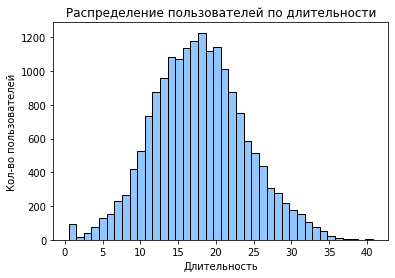

In [43]:
plt.style.use('seaborn-pastel')
rides['duration'].plot(kind='hist', ec='black', bins=40)
plt.title('Распределение пользователей по длительности')
plt.xlabel('Длительность')
plt.ylabel('Кол-во пользователей')

Выглядит как нормальное распределение

In [10]:
rides.duplicated().sum()

0

Явных дубликатов в таблице нет

Преходим к анализу последней таблицы - **subscriptions**

In [11]:
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Все типы данных поставлены верно, значения в таблице поставлены в соотвествии с тарифами.

**Вывод**

+ В таблице **users** есть несколько явных дубликатов
+ Во всех таблицах отсутствуют пропуски
+ В таблице **rides** столбец **date** следует привести к правильному типу данных
+ В таблице **rides** некоторые значения необходимо округлить для удобства 

## Шаг 2. Предобработка данных

Приведем к правильному типу данных столбец **date** в таблице **rides**

In [12]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Создадим новый столбец с номером месяца на основе столбца **date**

In [13]:
rides['month'] = rides['date'].apply(lambda x: x.month)

Посмотрим за какой период у нас данные, чтобы не возникло путаницы

In [44]:
print('Период дат из датафрейма: c', rides.date.min(),'по', rides.date.max())

Период дат из датафрейма: c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


Все данные в рамках одного года, так что все хорошо и волноваться не стоит

Кроме того, для большей читаемости и удобства округлим значения столбцов **distance** и **duration** до 2 знаков после запятой.

In [14]:
rides['distance'] = rides['distance'].round(2)
rides['duration'] = rides['duration'].round(2)

Взглянем на то, что получилось

In [15]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.92,25.60,2021-01-01,1
1,1,2617.59,15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,2694.78,18.51,2021-08-11,8
4,1,4028.69,26.27,2021-08-28,8


Теперь нам необходимо обработать уже найденные в предыдущем пункте дубликаты 

In [16]:
users['user_id'].duplicated().sum()

31

In [17]:
users = users.drop_duplicates()
print('Количество явных дубликатов в датасете:', users.duplicated().sum())

Количество явных дубликатов в датасете: 0


#### Вывод

+ Мы сменили тип данных  **date** в таблице **rides** на **datetime64**, а также добавили отдельный столбец **month**, где расположен номер каждого месяца
+ Мы убрали дубликаты в таблице **users**

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

In [45]:
print('Список уникальных наименований населенных пунктов:', len(users['city'].unique()))
(users['city'].value_counts())

Список уникальных наименований населенных пунктов: 8


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Выше можно увидеть кол-во уникальных городов, а также их частоту. Попробуем визуализировать в процентном отношении 

/tmp/ipykernel_48/3375091087.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


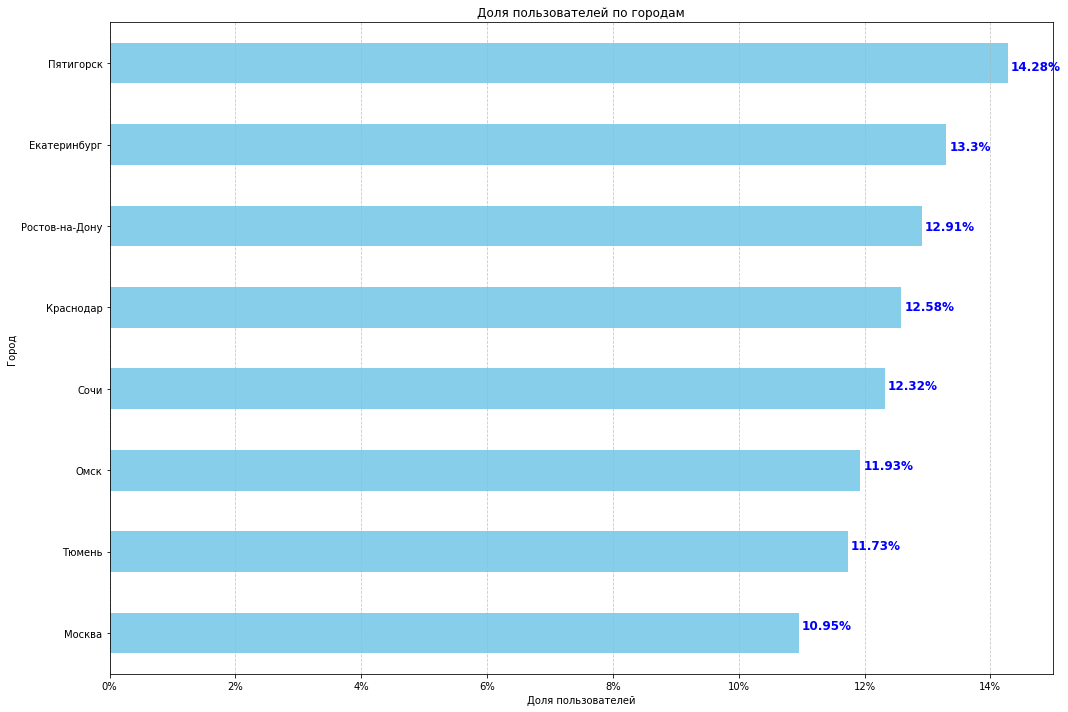

In [19]:
all_users = len(users)
users_for_barh = users.groupby('city').size()/all_users
users_for_barh_filt = users_for_barh.sort_values()
ax = users_for_barh_filt.plot(kind='barh', color='skyblue', figsize=(15,10))

labels = dict(users_for_barh_filt)

ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

plt.title('Доля пользователей по городам')
plt.xlabel('Доля пользователей')
plt.ylabel('Город')

# Добавление сетки
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Отображение графика
plt.tight_layout()
plt.show()

На удивление наименьшее кол-во пользователей сервиса расположено в **Москве**  **(10.95%)**, больше всего же пользователей из **Пятигорска** **(14.28%)**

### Соотношение пользователей с подпиской и без подписки

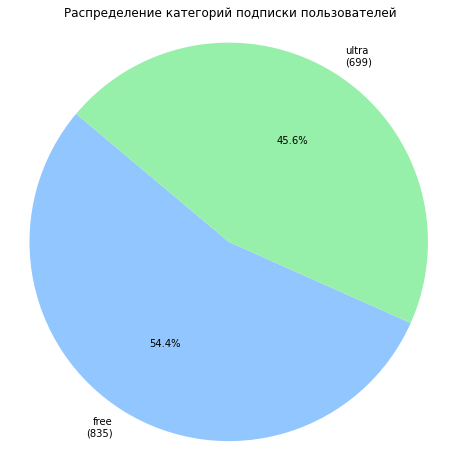

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Получение количества пользователей в каждой категории подписки
subscription_counts = users['subscription_type'].value_counts()

# Форматирование меток только с общим количеством
labels = [f'{label}\n({count})' for label, count in subscription_counts.items()]

plt.pie(subscription_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение категорий подписки пользователей')
plt.show()


Как мы можем наблюдать, большая часть пользователей пользуется тарифом **Free** (всего **835** пользователей), в то время как тарифом **Ultra** пользуется **45.6%** (**699** человек)

###  Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

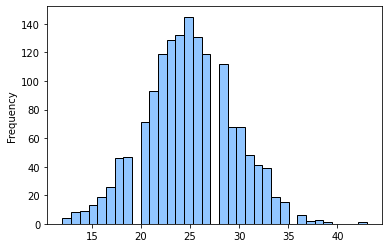

In [21]:
users['age'].plot(kind = 'hist', ec = 'black', bins = 35)
users['age'].describe()

Минимальный возраст - **12 лет**, максимальный - **43**, средний возраст пользователя услуг - **24.9 года**

Можно попробовать сегментировать распределение возраста по тарифу

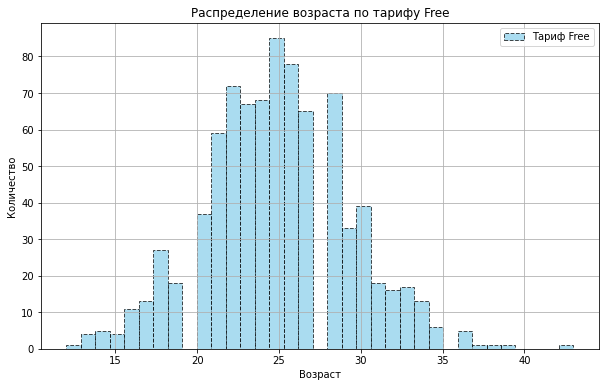

In [22]:
plt.figure(figsize=(10, 6)) # Размер графика

# Создаем подмножества данных для каждого тарифа
free_users = users[users['subscription_type'] == 'free']
free_users['age'].plot(kind='hist', ec='black', bins=35, color='skyblue', alpha=0.7, linestyle='dashed')

plt.xlabel('Возраст') # Название оси X
plt.ylabel('Количество') # Название оси Y
plt.title('Распределение возраста по тарифу Free') # Заголовок графика

plt.legend(['Тариф Free']) # Легенда для обозначения тарифов
plt.grid(True) # Включаем сетку
plt.show() # Показываем график

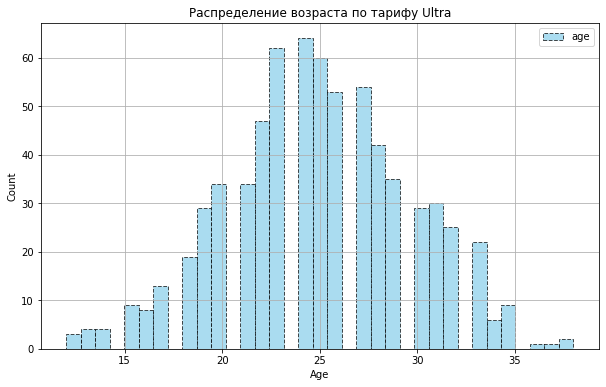

In [23]:
# Строим график
plt.figure(figsize=(10, 6)) # Размер графика
# Создаем подмножества данных для каждого тарифа
ultra_users = users[users['subscription_type'] == 'ultra']
ultra_users['age'].plot(kind='hist', ec='black', bins=35, color='skyblue', alpha=0.7, linestyle='dashed')
plt.xlabel('Age') # Название оси X
plt.ylabel('Count') # Название оси Y
plt.title('Распределение возраста по тарифу Ultra') # Заголовок графика
plt.legend() # Легенда для обозначения тарифов
plt.grid(True) # Включаем сетку
plt.show() # Показываем график

Пользователей тарифа **ultra** намного больше в возрастной категории **27-35 лет**, в возрастной категории **20-25 лет** значильно превосходит кол-во пользователей тарифа **free**

### Расстояние, которое пользователь преодолел за одну поездку

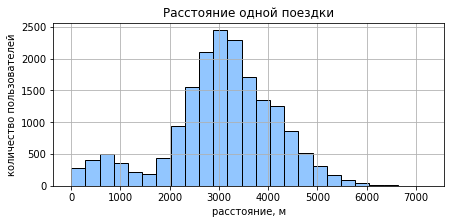

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

In [24]:
rides['distance'].plot(kind = 'hist', ec = 'black', grid=True, figsize = (7,3), bins = 25)
plt.title('Расстояние одной поездки')
plt.xlabel('расстояние, м')
plt.ylabel('количество пользователей')
plt.show()
rides['distance'].describe()

Большинство пользователей проезжает **3000 м**. Есть небольшой локальный рост в диапазоне до **1000 м**, вероятнее всего пользователи добирались до метро. 

### Продолжительность поездок.

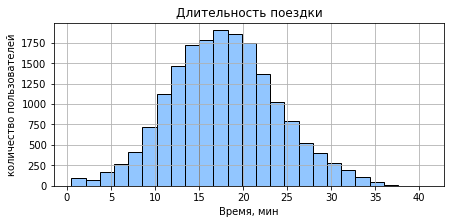

count    18068.000000
mean        17.805017
std          6.091071
min          0.500000
25%         13.600000
50%         17.680000
75%         21.722500
max         40.820000
Name: duration, dtype: float64

In [25]:
rides['duration'].plot(kind = 'hist', ec = 'black', grid=True, figsize = (7,3), bins = 25)
plt.title('Длительность поездки')
plt.xlabel('Время, мин')
plt.ylabel('количество пользователей')
plt.show()
rides['duration'].describe()

Напоминает распределение Гаусса. В среднем поездка занимает **17 минут**

Посмотрим на **boxplot**, чтобы сразу оценить предельные максимальные и минимальные значения (и аномальные в том числе)

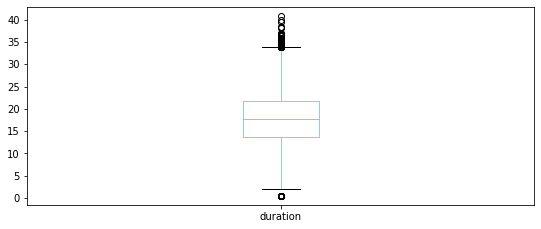

In [47]:
ax = rides['duration'].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8))

Предельные значения **duration** - от **4** до **34** минут (в рамках нормы), все остальное можно уже считать аномалиями

## Шаг 4. Объединение данных

###  Объединение данных о пользователях, поездках и подписках в один датафрейм

Предварительно проверим размерность датасетов до объединения

In [57]:
users.shape

(1534, 5)

In [58]:
subscriptions.shape

(2, 4)

In [26]:
mrg_tab = rides.copy()
mrg_tab = mrg_tab.merge(users, how = 'left', on = 'user_id' )
mrg_tab = mrg_tab.merge(subscriptions, how = 'left', on='subscription_type')
mrg_tab

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,19.82,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.42,21.41,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.19,18.44,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.31,16.67,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


И посмотрим на кол-во строк в результирущем датасете

In [59]:
mrg_tab.shape[0]

18068

### Датафрейм c данными о пользователях без подписки

In [27]:
mrg_tab_free = mrg_tab[mrg_tab['subscription_type'] == 'free']
display(mrg_tab_free.head())
print('Кол-во строк датасете с тарифом free:', mrg_tab_free.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,14.94,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,16.23,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,20.02,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,9.78,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,17.43,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Кол-во строк датасете с тарифом free: 11568


### Датафрейм с данными о пользователях с подпиской

In [28]:
mrg_tab_ult = mrg_tab[mrg_tab['subscription_type'] == 'ultra']
display(mrg_tab_ult.head())
print('Кол-во строк датасете с тарифом ultra:', mrg_tab_ult.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Кол-во строк датасете с тарифом ultra: 6500


### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

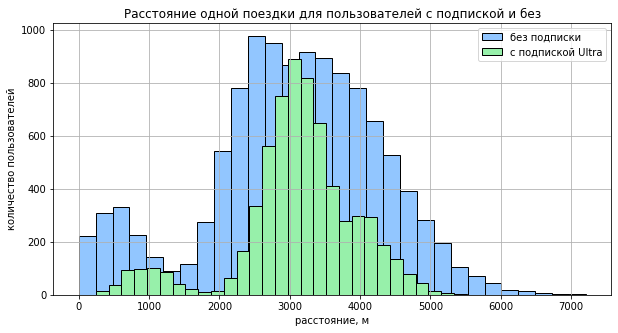

In [29]:
ax = mrg_tab_free['distance'].plot(kind = 'hist', ec = 'black', 
                                   grid=True, figsize = (10, 5), bins = 30, label='без подписки')
ax = mrg_tab_ult['distance'].plot(kind = 'hist', ec = 'black', 
                                  grid=True, figsize = (10, 5), bins = 30, label='с подпиской Ultra')
plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('расстояние, м')
plt.ylabel('количество пользователей')
plt.legend(loc='upper right')
plt.show()

Выше мы видим два сравнительных графика расстояний для пользователей с подписками **ultra** и **free**. Очевидно, пользователей с подпиской **ultra** намного меньше в целом и единственный пик, где их кол-во превосходит число пользователей с подпиской **free** - на **3100 м** 

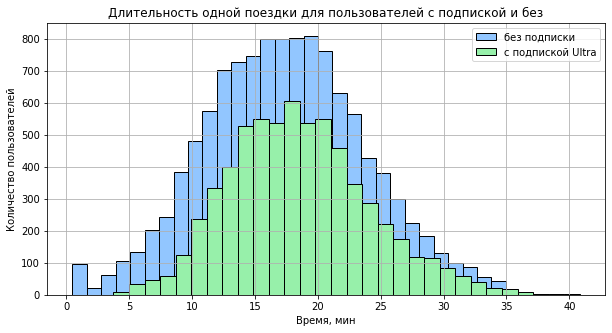

In [30]:
ax = mrg_tab_free['duration'].plot(kind = 'hist', ec = 'black', 
                                   grid=True, figsize = (10, 5), bins = 30, label='без подписки')
ax = mrg_tab_ult['duration'].plot(kind = 'hist', ec = 'black', 
                                  grid=True, figsize = (10, 5), bins = 30, label='с подпиской Ultra')
plt.title('Длительность одной поездки для пользователей с подпиской и без')
plt.xlabel('Время, мин')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

По такому графику тяжело определить что-то конретное, можно лишь сказать, что распределение походит на биноминальное. Построим boxplot, чтобы оценить предельные нормальные значения и отсечь аномальные

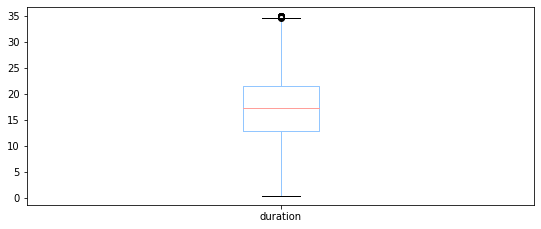

In [65]:
ax = mrg_tab_free['duration'].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8))

Медианное значение для пользователей бесплатного тарифа - **17**, предельное максимальное и минимальное - **35** и **1** соотвественно. Аномальных значений ниже минимального порога нет, все они сосредоточены за пределом **35**

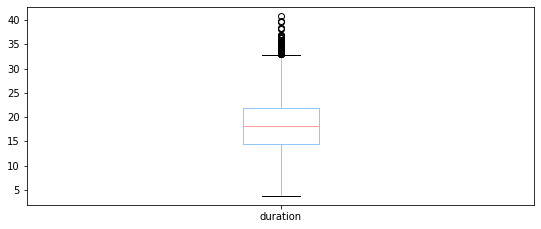

In [63]:
ax = mrg_tab_ult['duration'].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8))

Медианное значение для пользователей платного тарифа - **18**, предельное максимальное и минимальное - **33** и **5** соотвественно. Аномальных значений ниже минимального порога нет, все они сосредоточены за пределом **33**

## Шаг 5. Подсчёт выручки

Нам необходимо сделать таблицу с агрегированными данными о поездках: **суммарное расстояние, количество поездок** и **суммарное время** для каждого пользователя за каждый месяц. Но кроме того, нам нужно проверить сводную таблицу на наличие пропусков. 

In [68]:
mrg_tab.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

К счастью, пропусков нет, поэтому со спокойной душой можно проводить вычисления 

In [31]:
# округлим время поезки до следующего целого числа
mrg_tab['duration'] = np.ceil(mrg_tab['duration'])
mrg_tab['duration'] = mrg_tab['duration'].astype('int')

mrg_tab_agg = mrg_tab.pivot_table(index= ['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
mrg_tab_agg.columns = ['_'.join(col) for col in mrg_tab_agg.columns.values]
mrg_tab_agg = mrg_tab_agg.drop(columns=['count_duration'])
mrg_tab_agg = mrg_tab_agg.reset_index()
display(mrg_tab_agg)

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.51,42
1,1,4,1,754.16,7
2,1,8,2,6723.47,46
3,1,10,2,5809.91,32
4,1,11,3,7003.50,56
...,...,...,...,...,...
11326,1534,6,2,3409.47,26
11327,1534,8,2,7622.45,48
11328,1534,9,1,4928.17,23
11329,1534,11,4,13350.02,78


Мы построили сводную таблицу, где **count_distance - кол-во поездок в месяц, sum_distance - суммарная длина пути (в метрах)** и **sum_duration - общая длительность (в минутах)**

Теперь же объединим все данные в одну таблицу **mrg_tab_agg** и посмотрим на то, что получилось

In [32]:
mrg_tab_agg = mrg_tab_agg.merge(users, how='left', on='user_id')
mrg_tab_agg = mrg_tab_agg.merge(subscriptions, how = 'left', on='subscription_type')
display(mrg_tab_agg)

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.51,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.16,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.47,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.91,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.50,56,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,Альберт,25,Краснодар,free,8,50,0
11327,1534,8,2,7622.45,48,Альберт,25,Краснодар,free,8,50,0
11328,1534,9,1,4928.17,23,Альберт,25,Краснодар,free,8,50,0
11329,1534,11,4,13350.02,78,Альберт,25,Краснодар,free,8,50,0


In [33]:
def month_sum(row):
    gain_sum = 0 
    gain_sum = (row['start_ride_price'] * row['count_distance'] +
                row['minute_price'] * row['sum_duration'] +
                row['subscription_fee'])
    return gain_sum 

mrg_tab_agg['month_gain'] =  mrg_tab_agg.apply(month_sum, axis = 1)  
display(mrg_tab_agg[['user_id', 'month', 'name', 'month_gain']])             

,user_id,month,name,month_gain
0,1,1,Кира,451
1,1,4,Кира,241
2,1,8,Кира,475
3,1,10,Кира,391
4,1,11,Кира,535
...,...,...,...,...
11326,1534,6,Альберт,308
11327,1534,8,Альберт,484
11328,1534,9,Альберт,234
11329,1534,11,Альберт,824


## Шаг 6. Проверка гипотез

### Гипотеза 1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть "выгоднее" для компании. Необходимо проверить эту гипотезу. Используя исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки. 

Для начала мы просто вычленим две отдельные выборки по категории подписки - **ultra** и **free** 

+ Нулевая гипотеза: среднее время поездок пользователей с подпиской и пользователей без подписки равно или меньше
+ Альтернативная гипотеза: пользователи с подпиской тратят больше времени

In [34]:
alpha = 0.05

result = st.ttest_ind(mrg_tab_ult['duration'], mrg_tab_free['duration'], alternative = 'greater')

print('Значение p', result.pvalue)

if alpha > result.pvalue:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Значение p 1.274138957151199e-34
Отвергаем нулевую гипотезу


Различия между выборками статистически значимо, мы отклоняем нулевую гипотезу, пользователи с подпиской тратят больше времени, нежели пользователи без подписки 

In [35]:
print('Среднее время пользователей без подписки', round(mrg_tab_free['duration'].mean(), 2))
print('Среднее время пользователей с подпиской', round(mrg_tab_ult['duration'].mean(), 2))

Среднее время пользователей без подписки 17.39
Среднее время пользователей с подпиской 18.54


Это действительно так, мы в этом убедились 

### Гипотеза 2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим эту гипотезу и сделаем выводы

+ Нулевая гипотеза: среднее расстояние поездки пользователи с подпиской равно 3130 метрам
+ Альтернативная гипотеза: расстояние поездки пользователя с подпиской больше 3130 метров

In [69]:
imp_value = 3130

alpha = 0.05

result = st.ttest_1samp(mrg_tab_ult['distance'], imp_value, alternative = 'greater')

print('Значение p', result.pvalue)

if alpha > result.pvalue:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Значение p 0.9195362605842414
Нет оснований отвергнуть нулевую гипотезу


Поскольку p-значение больше уровня статистической значимости, нет причин для того, чтобы отвергнуть эту нулевую гипотезу.

In [37]:
print('Среднее расстояние поездки пользователя с подпиской', round(mrg_tab_ult['distance'].mean(), 2))

Среднее расстояние поездки пользователя с подпиской 3115.45


###  Гипотеза 3

Сначала нам нужно поменять сводные таблицы с данными

In [38]:
mrg_tab_agg_ult = mrg_tab_agg[mrg_tab_agg['subscription_type'] == 'ultra']
mrg_tab_agg_free =  mrg_tab_agg[mrg_tab_agg['subscription_type'] == 'free']

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

+ Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна выручке пользователей без подписки 
+ Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше выручки пользователей без подписки 

In [39]:
alpha = 0.05 

results = st.ttest_ind(mrg_tab_agg_ult['month_gain'], mrg_tab_agg_free['month_gain'], alternative='greater')

print('p-значение:', results.pvalue)

if alpha > results.pvalue:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8164914860049708e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователи с подпиской больше.

###  Гипотеза 4

Предположим, что техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Нам необходимо определить какой тест понадобился бы для проверки этой гипотезы.

Для проверки гипотезы, стоит применить метод о равенстве среднего генеральной совокупности для зависимых выборок, то есть необходимо применить **scipy.stats.ttest_rel()**

При проверке этой гипотезы, используется левосторонний тест. Это связано с тем, что интерес представляет собой снижение количества обращений, и мы хотим определить, есть ли статистически значимое снижение.

Таким образом, в данной ситуации необходим именно левосторонний тест

## Шаг 7. Распределения

### Задача 1

Отделу маркетинга **GoFast** поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Как написано выше, у нас есть всего 2 исхода (пользователь либо отказывается от подписки, либо продляет ее) в серии независимых испытаний. Соотвественно под это определение подходит биноминальное распределение.

<BarContainer object of 1001 artists>

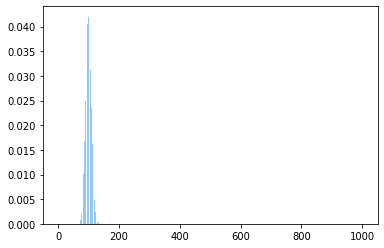

In [40]:
n = 1000
p = 0.1
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)

plt.bar(range(0, n + 1), distr)

В диапазоне (n-500, n+500) определим минимальное количество промокодов чтобы вероятность не выполнить план была не больше 5%

In [41]:
for n in range (500, 1500):
    if binom.cdf(99, n, 0.1) < 0.05:
        print("Минимальное число промокодов:", n)
        break

Минимальное число промокодов: 1161


Для акции раздачи промокодов с целью получения не менее 100 продлений подписок, с вероясностью невыполнения не больше 5% нужно сделать рассылку не менее 1161 промокодов

### Задача 2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В данном случае мы вновь имеем дело с биноминальным распределением (последовательность независимых событий с двумя возможными исходами), но из-за огромного числа уведомлений (**1 млн**), биноминальное распределение можно апроксимировать нормальным из-за **ЦПТ** (Сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы, имеет распределение, близкое к нормальному)

In [42]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma)

x = 399500

# считаем вероятность получить значение, равное x или меньше
result = distr.cdf(x)

print('Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей:',
      round(result, 2))

Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15


В условиях акции рассылки 1 млн. push-уведомлений вероятность что откроют их не более 399,5 тыс. пользователей - 15%

## Вывод

+ По предоставленным данным из 8-и городов, больше всего пользователей из Пятигорска, меньше всего из Москвы.
+ Средний возраст пользователя сервиса - 24.9 лет
+ Среднее расстояние большинства поездок чуль больше 3-х километров. Есть небольшой всплеск около поездок на 600м, можно предположить что эти поезки совершали пользователи, что бы добраться до станций метро или других остановок общественного транспорта
+ Пользователей сервиса аренды самокатов без подписки больше чем пользователей с подпиской на **9%**.
+ Средняя помечная выручка от пользователей с подпиской больше чем от пользователей без подписки

**В ходе исследования были подтверждены следующие гипотезы:**
1) с вероятностью **5%** время поездок пользователей с подпиской больше время поездок пользователей без подписки

2) средняя дистанция поездки пользователи с подпиской меньше **3130 метров** (оптимальное расстояние с точки зрения износа самоката)

3) помесячная выручка от пользователей с подпиской выше чем выручка от пользователей без подписки

**Так же, для отдела маркетинга сделаны расчеты:**

1) Для акции раздачи промокодов с целью получения не менее **100** продлений подписок: с нужно сделать рассылку не менее **1161** промокодов

2) Для акции рассылки **1 млн.** push-уведомлений вероятность что откроют их не более **399,5 тыс.** пользователей - **15%**

### Рекомендации

Теперь, когда в распоряжении у нас есть данные, мы можем сформулировать основные рекомендации для повышения прибыльности сервиса. 

+ Улучшение аналитики и прогнозирования: Непрерывный мониторинг и анализ данных о пользователях (желательно пользователей дифференцировать по разным группам и категориям населения) и поездках могут помочь GoFast более точно прогнозировать спрос и разрабатывать более точные стратегии развития. 

+ Развитие гибких тарифов: Вытекая из первой рекомендации, если более точечно кластеризировать разные группы пользователей по каким-либо признакам, может позволить GoFast создавать гибкие тарифы и предложения. Это может включать в себя краткосрочные подписки, пакетные предложения и другие варианты, удовлетворяющие потребности разных клиентов.

+ Стимулирование интенсивного использования сервиса: Пользователи, которые проводят больше времени в поездках, могут быть ценными клиентами. Можно разработать программы лояльности, предоставляющие скидки или бонусы тем пользователям, которые активно используют сервис.

+ Продвижение подписок: Учитывая, что пользователи с подпиской более активно используют сервис, стоит активно продвигать подписки среди пользователей. Это может включать в себя разработку маркетинговых кампаний, предоставление дополнительных привилегий для подписчиков и сезонные акции на подписки.